<a href="https://colab.research.google.com/github/Mt-river/Timetable-SNU-Musikverein/blob/main/DL_day9/9_1_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Networks

Reference: https://github.com/eriklindernoren/PyTorch-GAN/tree/master


In [12]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=20, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.001, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epochs=20, batch_size=64, lr=0.001, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=28, channels=1, sample_interval=400)


In [13]:
# Image 크기 및 Cuda 설정

img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False
cuda

True

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024)
            *block(1024, 2048)
            nn.Linear(2048, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [15]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [16]:
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

In [17]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

[Epoch 0/20] [Batch 0/938] [D loss: 0.679960] [G loss: 0.722054]


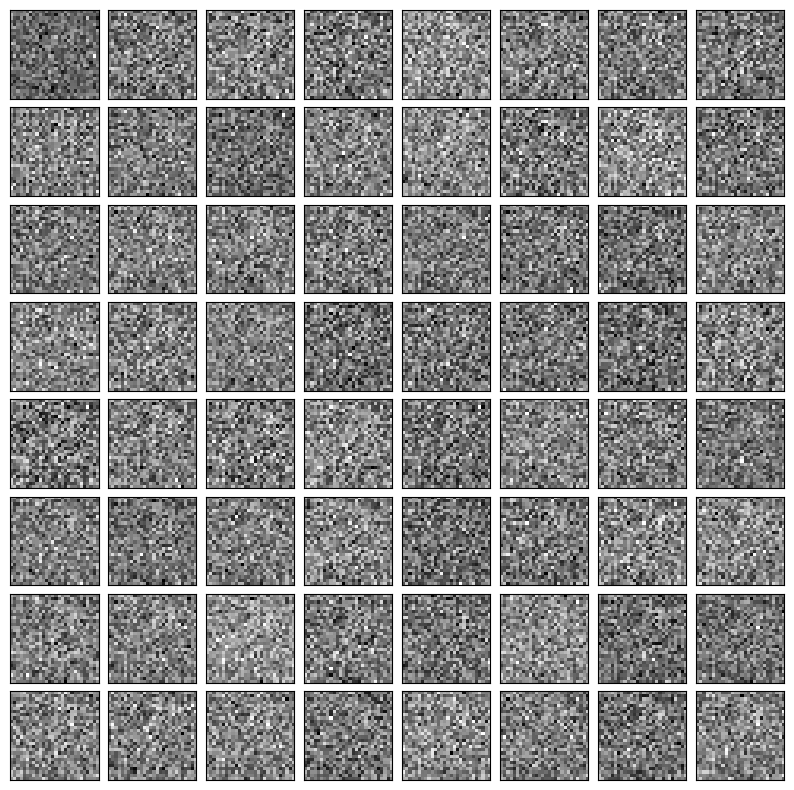

[Epoch 0/20] [Batch 600/938] [D loss: 0.642230] [G loss: 0.395879]


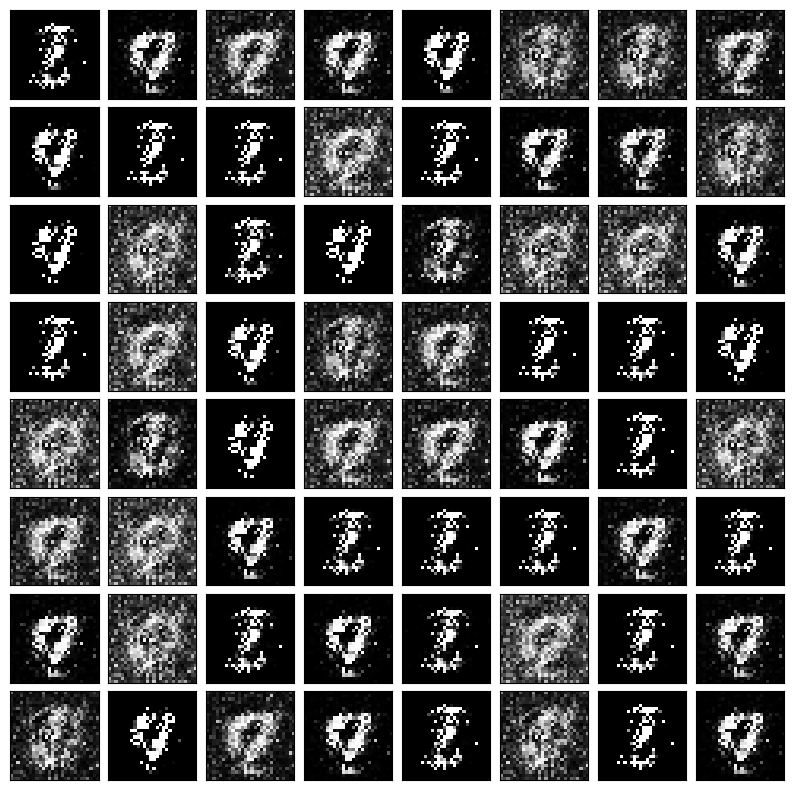

[Epoch 1/20] [Batch 0/938] [D loss: 0.420485] [G loss: 3.216407]


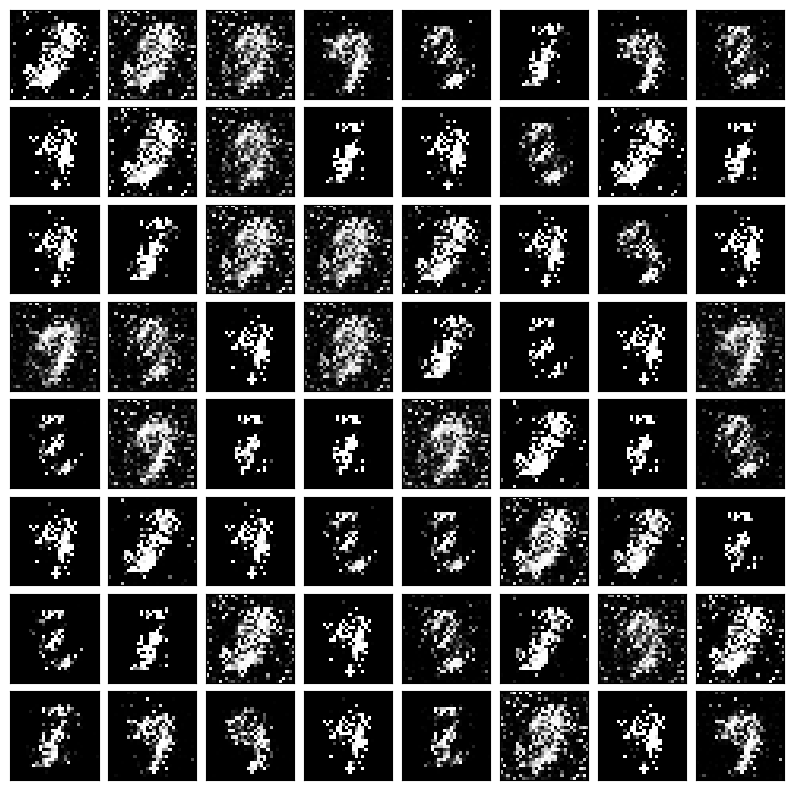

[Epoch 1/20] [Batch 600/938] [D loss: 0.354802] [G loss: 1.887376]


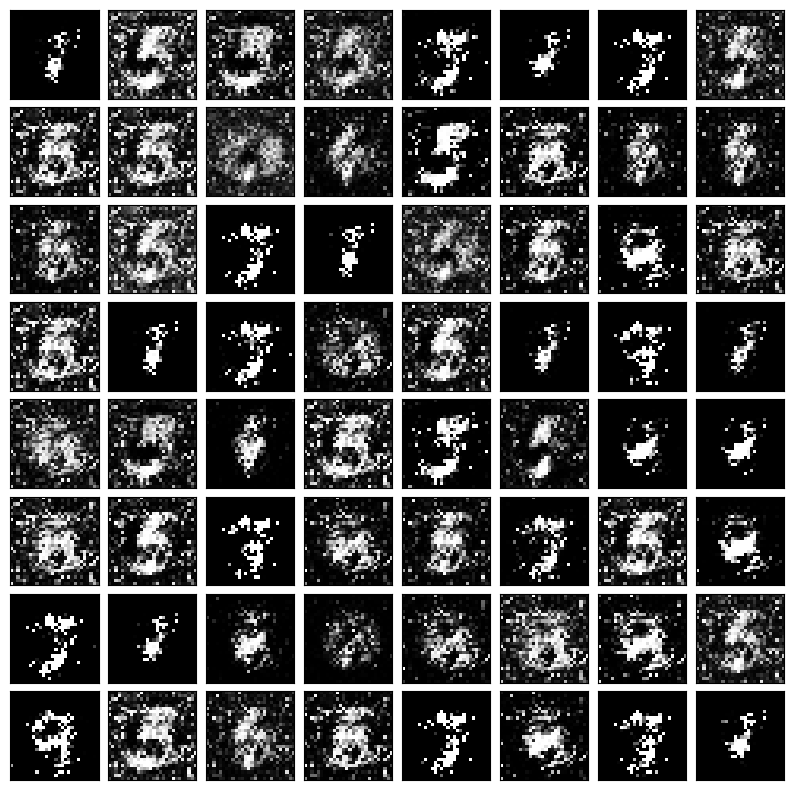

[Epoch 2/20] [Batch 0/938] [D loss: 0.611461] [G loss: 1.828265]


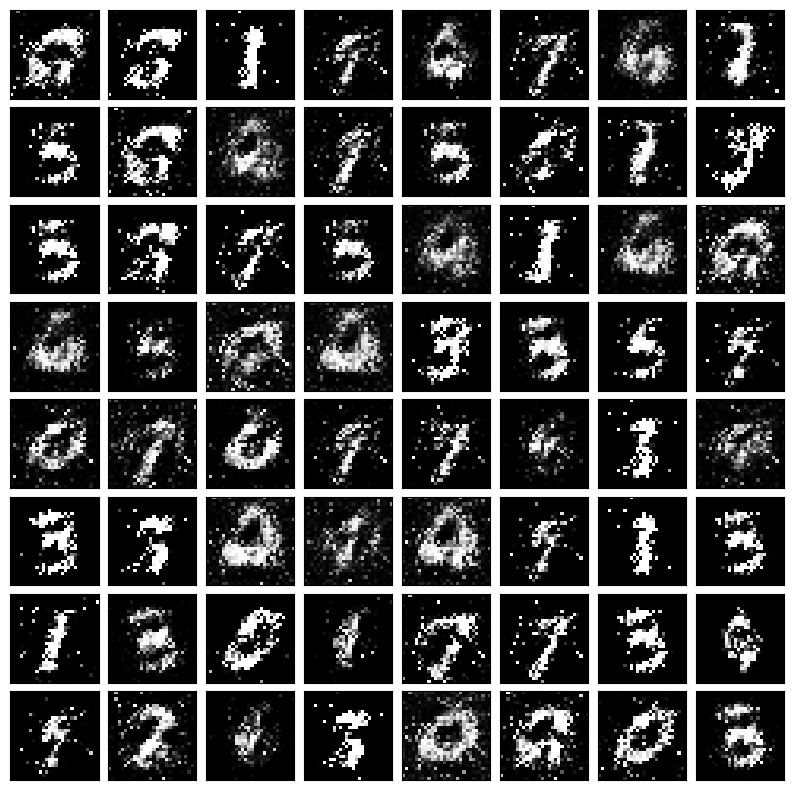

[Epoch 2/20] [Batch 600/938] [D loss: 0.445612] [G loss: 1.168048]


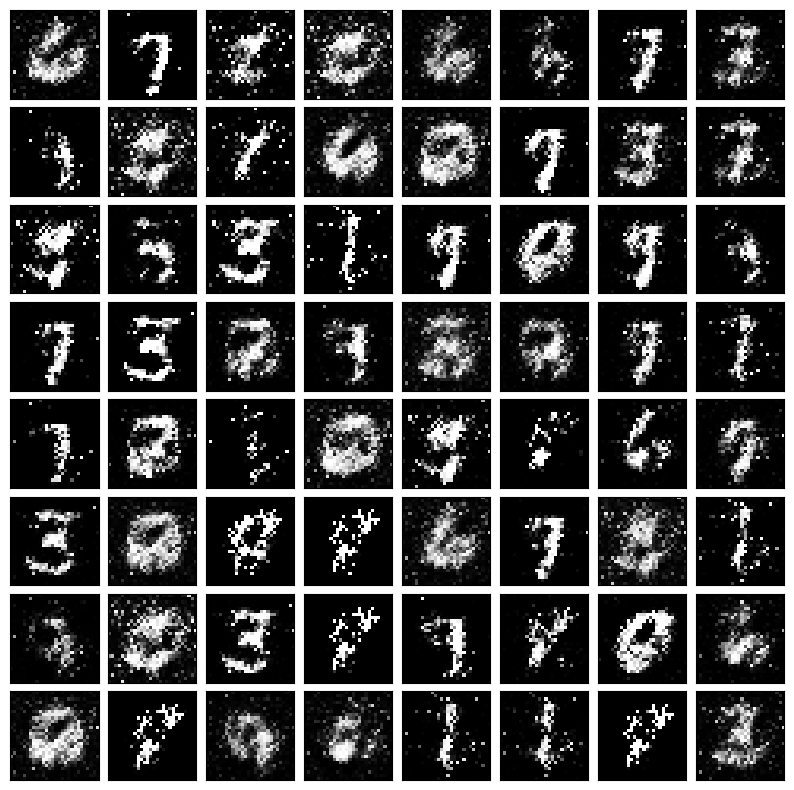

[Epoch 3/20] [Batch 0/938] [D loss: 0.386555] [G loss: 1.338472]


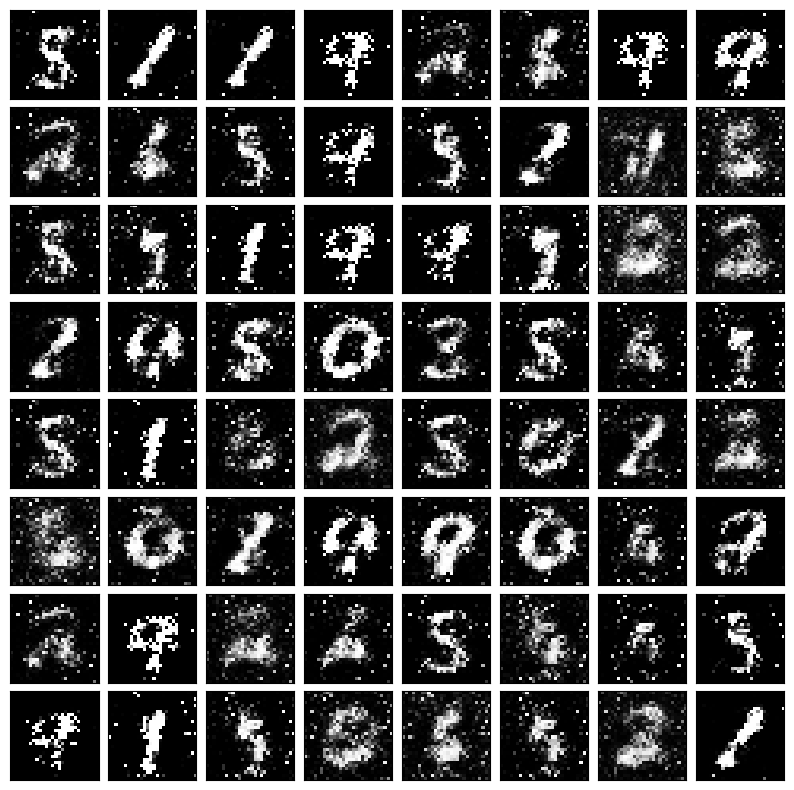

In [ ]:
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()


        if i%600==0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
            images = gen_imgs.data.detach().cpu()
            images = images * 0.5 + 0.5  # Revert the normalization to visualize the images properly

            # Create a figure to display the images in an 8x8 grid
            fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
            plt.subplots_adjust(wspace=0.1, hspace=0.1)

            # Plot each image in the 8x8 grid
            for i, ax in enumerate(axes.flat):
                ax.imshow(images[i].squeeze(), cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])


            plt.show()
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)